In [2]:
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact, chisquare
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
# sharper plots
%config InlineBackend.figure_format = 'retina'

import os, re

In [13]:
df = pd.read_csv("E:\\.ML\\[Анатолий Карпов] [Stepic] Data Analytic Часть 1\\5\\Задания\\data.csv.zip", encoding='ISO-8859-1')

In [16]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [17]:
df.drop_duplicates(inplace=True)

In [19]:
df[df.InvoiceNo.str.startswith("C")].shape

(9251, 8)

In [21]:
retail = df[df.Quantity > 0]

In [38]:
cust_bought_num = retail[retail.Country == "Germany"].groupby('CustomerID', as_index=False).InvoiceNo.count()
germany_top = cust_bought_num.query('InvoiceNo > ' + str(cust_bought_num['InvoiceNo'].quantile(0.8))).CustomerID.reset_index().CustomerID
germany_top

0     12471.0
1     12472.0
2     12473.0
3     12474.0
4     12476.0
5     12477.0
6     12481.0
7     12517.0
8     12569.0
9     12621.0
10    12626.0
11    12627.0
12    12662.0
13    12668.0
14    12705.0
15    12708.0
16    12709.0
17    12720.0
18    13815.0
Name: CustomerID, dtype: float64

In [39]:
top_retail_germany = retail[retail.CustomerID.isin(germany_top)]
top_retail_germany

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1109,536527,22809,SET OF 6 T-LIGHTS SANTA,6,12/1/2010 13:04,2.95,12662.0,Germany
1110,536527,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,6,12/1/2010 13:04,2.55,12662.0,Germany
1111,536527,84945,MULTI COLOUR SILVER T-LIGHT HOLDER,12,12/1/2010 13:04,0.85,12662.0,Germany
1112,536527,22242,5 HOOK HANGER MAGIC TOADSTOOL,12,12/1/2010 13:04,1.65,12662.0,Germany
1113,536527,22244,3 HOOK HANGER MAGIC GARDEN,12,12/1/2010 13:04,1.95,12662.0,Germany
...,...,...,...,...,...,...,...,...
541726,581570,22139,RETROSPOT TEA SET CERAMIC 11 PC,3,12/9/2011 11:59,4.95,12662.0,Germany
541727,581570,23077,DOUGHNUT LIP GLOSS,20,12/9/2011 11:59,1.25,12662.0,Germany
541728,581570,20750,RED RETROSPOT MINI CASES,2,12/9/2011 11:59,7.95,12662.0,Germany
541729,581570,22505,MEMO BOARD COTTAGE DESIGN,4,12/9/2011 11:59,4.95,12662.0,Germany


In [79]:
top_retail_germany.query('StockCode != "POST"').groupby('StockCode', as_index=False).Description.count() \
                .sort_values(by="Description", ascending=False).reset_index().drop(columns='index')


,StockCode,Description
0,22326,70
1,22328,46
2,22423,42
3,20719,37
4,22554,37
...,...,...
1287,22189,1
1288,22190,1
1289,22201,1
1290,22202,1


In [78]:
top_retail_germany.StockCode.value_counts()

POST     180
22326     70
22328     46
22423     42
20719     37
        ... 
22040      1
23107      1
22430      1
72812      1
22608      1
Name: StockCode, Length: 1293, dtype: int64

In [90]:
#retail = retail.assign(Revenue = retail.Quantity * retail.UnitPrice)
retail['Revenue'] = retail.Quantity * retail.UnitPrice
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


#### Для каждой транзакции (InvoiceNo), посчитайте финальную сумму заказа. В качестве ответа укажите топ-5 (InvoiceNo) по сумме заказа (через запятую с пробелом и в порядке убывания TotalRevenue)

In [89]:
retail.groupby("InvoiceNo", as_index=False).Revenue.sum().sort_values(by='Revenue', ascending=False).head(5).InvoiceNo

20689    581483
2202     541431
17582    574941
18251    576365
9034     556444
Name: InvoiceNo, dtype: object

## 2nd Part

In [143]:
df = pd.read_csv("E:\\.ML\\[Анатолий Карпов] [Stepic] Data Analytic Часть 1\\5\\Задания\\Минипроект\\transaction_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5315 entries, 0 to 5314
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         5315 non-null   object
 1   name         5315 non-null   object
 2   transaction  5315 non-null   object
dtypes: object(3)
memory usage: 124.7+ KB


In [144]:
df.head()

,date,name,transaction
0,2020-03-02 00:37:20,Ekaterina_Petrova,cancelled
1,2020-03-02 00:59:09,Irina_Fedorova,successfull
2,2020-03-02 01:06:14,Ekaterina_Smirnova,successfull
3,2020-03-02 00:02:58,Lolita_Polyanova,cancelled
4,2020-03-02 00:17:52,Julia_Smirnova,cancelled


In [145]:
df.replace("successfull", 'successful', inplace=True)

#### Какие значения находятся в колонке transaction? Сколько наблюдений относятся к тому или иному уровню? Визуализируйте результат с помощью барплота. Подумайте, как можно улучшить график.

In [146]:
df.transaction.unique()

array(['cancelled', 'successful', 'error'], dtype=object)

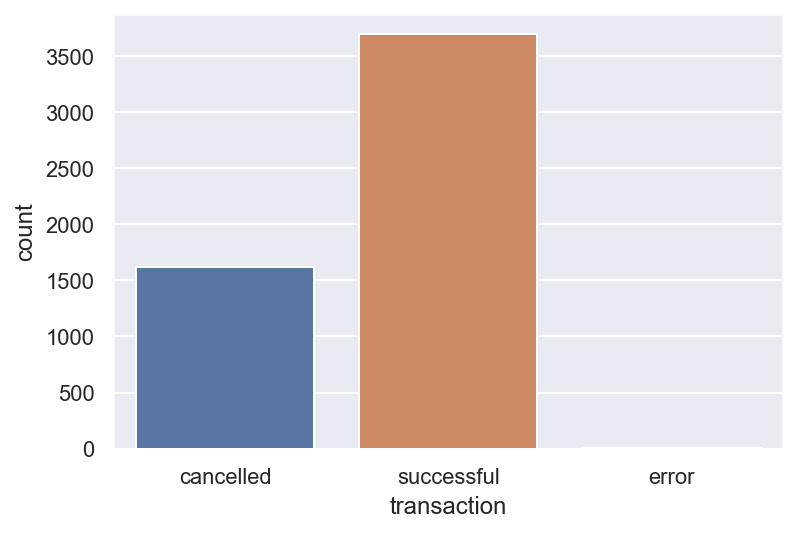

In [147]:
sns.countplot(df.transaction);

In [148]:
df.transaction.value_counts().error

4

array([[<AxesSubplot:title={'center':'transaction'}>]], dtype=object)

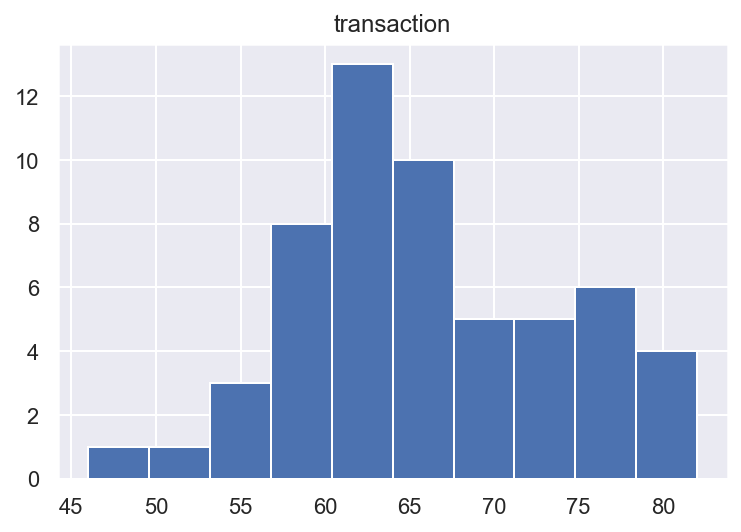

In [149]:
df.query('transaction == "successful"').groupby('name', as_index=False).transaction.count().hist()

#### Коллега прислал Вам обновленные данные. (transaction_data_updated.csv)
#### Постройте сводную таблицу user_vs_minute_pivot, где в качестве столбцов будут использованы имена пользователей, строк – минуты, значений – число совершенных операций в указанную минуту. Пропущенные значения заполните нулями.

In [150]:
df_upd = pd.read_csv("E:\\.ML\\[Анатолий Карпов] [Stepic] Data Analytic Часть 1\\5\\Задания\\Минипроект\\transaction_data_updated.csv")

In [159]:
trans_numb = df_upd.groupby(['name', 'minute'], as_index=False).transaction.count()
trans_numb

,name,minute,transaction
0,Ekaterina_Fedorova,0,3
1,Ekaterina_Fedorova,1,4
2,Ekaterina_Fedorova,2,1
3,Ekaterina_Fedorova,3,3
4,Ekaterina_Fedorova,4,3
...,...,...,...
2573,Vasilisa_Smirnova,52,1
2574,Vasilisa_Smirnova,53,1
2575,Vasilisa_Smirnova,54,2
2576,Vasilisa_Smirnova,56,3


In [167]:
trans_numb.pivot(index='name', columns='minute').fillna(0).head()

transaction                                               \
minute                      0    1    2    3    4    5    6    7    8    9    
name                                                                          
Ekaterina_Fedorova         3.0  4.0  1.0  3.0  3.0  3.0  4.0  3.0  2.0  2.0   
Ekaterina_Ivanova          4.0  4.0  2.0  0.0  0.0  0.0  1.0  2.0  4.0  4.0   
Ekaterina_Lesnova          2.0  0.0  4.0  2.0  0.0  2.0  2.0  1.0  3.0  2.0   
Ekaterina_Ozerova          3.0  4.0  4.0  0.0  3.0  3.0  2.0  2.0  1.0  3.0   
Ekaterina_Petrova          4.0  2.0  2.0  5.0  1.0  1.0  0.0  2.0  0.0  4.0   

                    ...                                                    
minute              ...   50   51   52   53   54   55   56   57   58   59  
name                ...                                                    
Ekaterina_Fedorova  ...  1.0  1.0  2.0  1.0  2.0  0.0  0.0  1.0  0.0  1.0  
Ekaterina_Ivanova   ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  2.0  1.0  
Ekaterina_Lesnova   ...  0.0  2.0  2.0  0.0  1.0  3.0  0.0  2.0  1.0  1.0  
Ekaterina_Ozerova   ...  3.0  1.0  3.0  0.0  1.0  2.0  2.0  1.0  0.0  1.0  
Ekaterina_Petrova   ...  1.0  5.0  1.0  1.0  0.0  2.0  0.0  1.0  0.0  1.0  

[5 rows x 60 columns]

In [171]:
pivot = df_upd.pivot_table(index='name', columns='minute', values='transaction', aggfunc='count', fill_value=0)

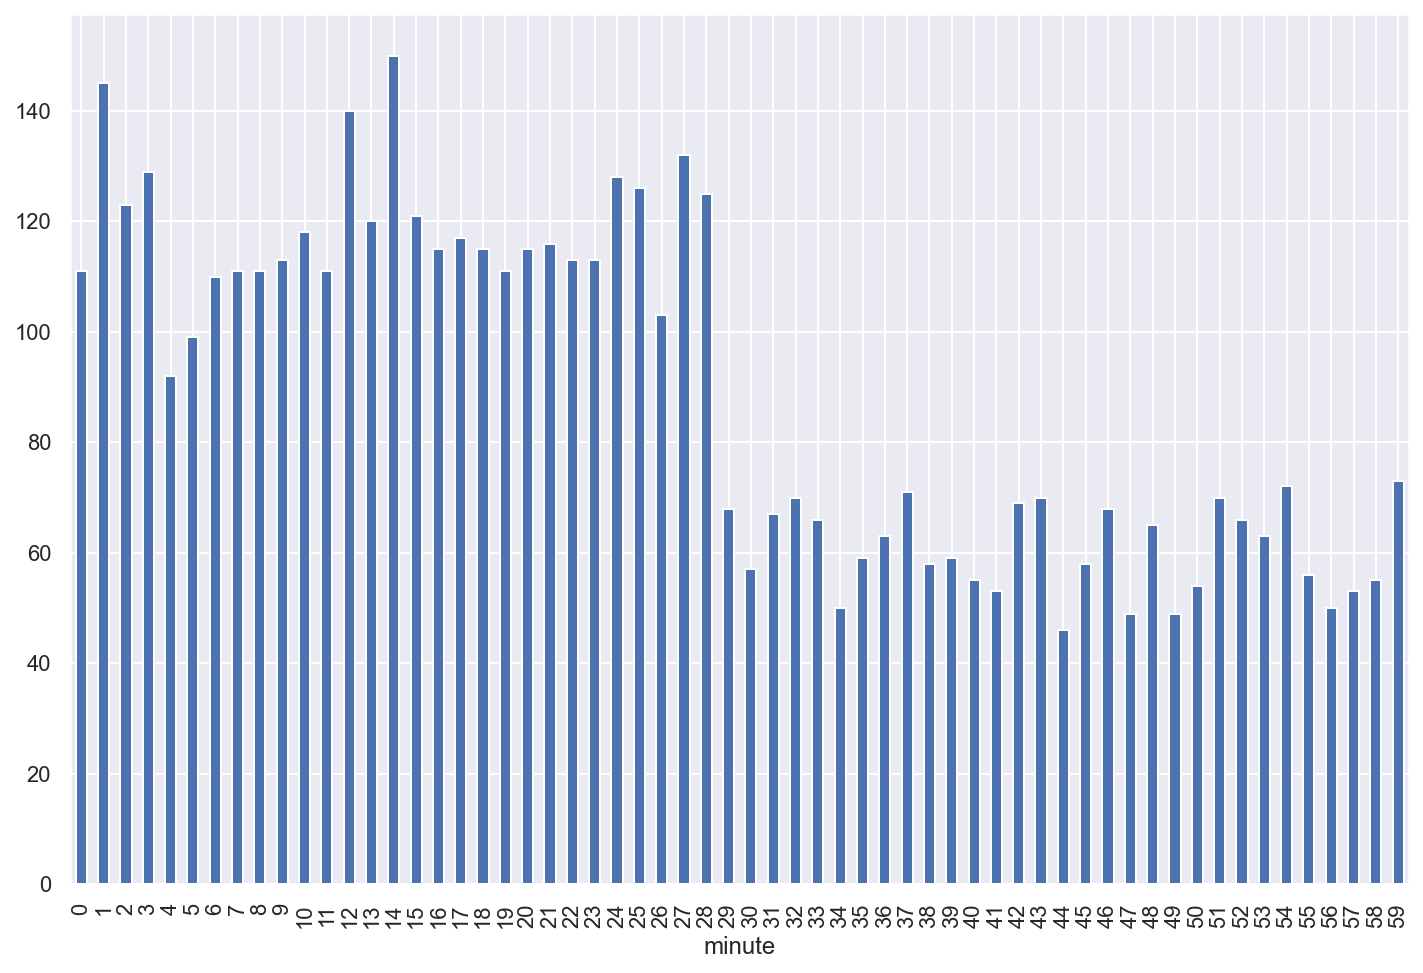

In [177]:
pivot.sum(axis=0).plot(kind='bar', figsize=(12, 8));

### Ошибка в неправльной колонке minutes. Минуты не включают в себя часы. Исправим.

In [183]:
df_upd['date'] = pd.to_datetime(df_upd['date'])
df_upd['true_minutes'] = df_upd.date.dt.hour * 60 + df_upd.date.dt.minute
df_upd

,date,name,transaction,minute,true_minutes
0,2020-03-02 00:37:20,Ekaterina_Petrova,cancelled,37,37
1,2020-03-02 00:59:09,Irina_Fedorova,successfull,59,59
2,2020-03-02 01:06:14,Ekaterina_Smirnova,successfull,6,66
3,2020-03-02 00:02:58,Lolita_Polyanova,cancelled,2,2
4,2020-03-02 00:17:52,Julia_Smirnova,cancelled,17,17
...,...,...,...,...,...
5310,2020-03-02 00:09:28,Vasilisa_Fedorova,successfull,9,9
5311,2020-03-02 00:46:31,Vasilisa_Ozerova,successfull,46,46
5312,2020-03-02 00:16:38,Olga_Polyanova,successfull,16,16
5313,2020-03-02 00:13:00,Ekaterina_Smirnova,successfull,13,13


In [184]:
pivot2 = df_upd.pivot_table(index='name', columns='true_minutes', values='transaction', aggfunc='count', fill_value=0)

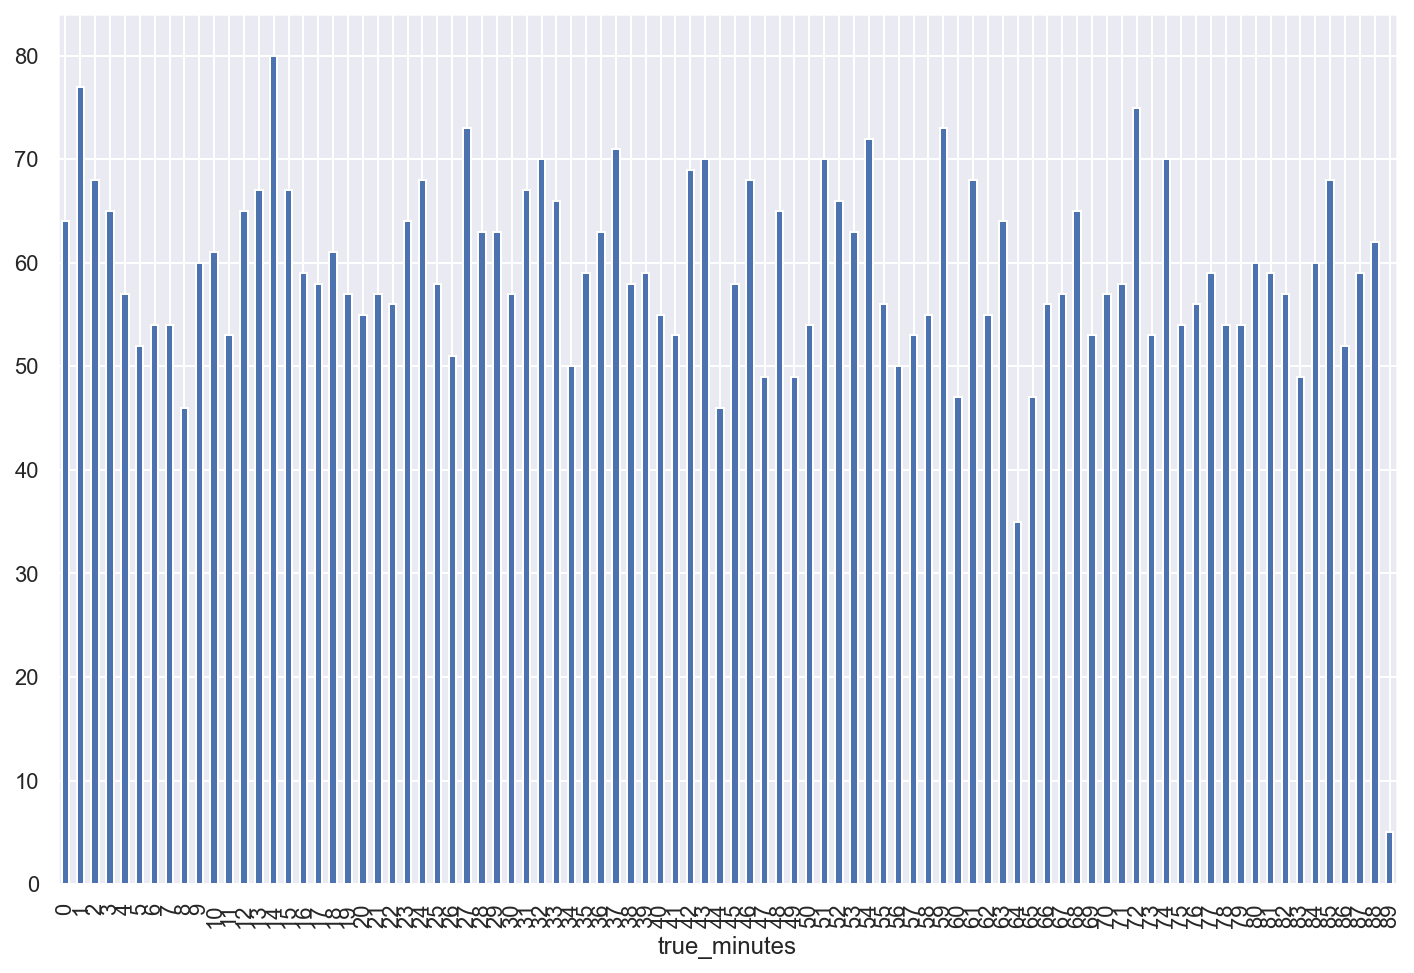

In [185]:
pivot2.sum(axis=0).plot(kind='bar', figsize=(12, 8));